In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
from ndcg_calc import ndcg_calc
warnings.filterwarnings('ignore')
from sklearn import cross_validation

In [2]:
train_orig = pd.read_csv('processed_data_final/train_clean.csv')

In [3]:
# divide the training set into subsamples for: feature engineering (position modeling), cross-validation, single training, single validation

all_srch_ids = train_orig.srch_id.unique()
num_samples_pos = int(0.25*len(all_srch_ids)) # 25%
num_samples_train = int(0.5*len(all_srch_ids)) # 50%
np.random.seed(0)
position_model_ids = np.random.choice(all_srch_ids, num_samples_pos, replace=False)
xval_ids = list(set(all_srch_ids)-set(position_model_ids))

#validation_ids = list(set(xval_ids)-set(training_ids))

xval_data = train_orig[train_orig.srch_id.isin(xval_ids)]

# reducing the size of the cross-validation set
#np.random.seed() # reset the random seed to avoid getting the same xval ids



'\nfraction_for_model = 0.75 #\n\nmodel_ids = np.random.choice(xval_ids, int(len(xval_ids)*fraction_for_model), replace=False)\n\nuntouched_ids = list(set(xval_ids) - set(model_ids))\nuntouched_sample = train_orig[train_orig.srch_id.isin(untouched_ids)]\n\n\nnum_samples_train =int(0.8*len(model_ids))\ntraining_ids = np.random.choice(model_ids, num_samples_train, replace=False)\n\n\nval_ids = list(set(model_ids)-set(training_ids))\n# untouched sample is left for extra validation and also because my memory cannot cope\ntraining_sample = train_orig[train_orig.srch_id.isin(training_ids)]\nval_sample = train_orig[train_orig.srch_id.isin(val_ids)]\n'

In [15]:
# free memory
del(train_orig)

In [4]:
# feature set
cols_to_use_RF = ['srch_id',
                'prop_id',
                'prop_location_score2',
                'prop_log_historical_price',
                'price_usd',
                'srch_booking_window',
                'orig_destination_distance',
                'price_diff_filled',
                'price_usd_norm_srch_id',
                'price_usd_norm_srch_destination_id',
                'prop_location_score2_norm_srch_destination_id',
                'prop_review_score_norm_srch_id',
                'prop_location_score1_norm_srch_id',
                'prop_location_score2_norm_srch_id',
                'prop_desirability_incomplete',
                'position_estimate',
                'prop_location_score_combined_norm_srch_id',
                'price_usd_norm_site_id',
                'prop_location_score2_norm_site_id',
                'prop_location_score_combined_norm_site_id',
                'avg_prop_price_usd',
                'avg_prop_location_score2',
                'avg_prop_location_score_combined',
                'booked_clicked_combined']

cols_to_use_GBM = ['srch_id',
                   'avg_prop_price_usd',
                   'prop_desirability',
                   'price_usd_norm_srch_id', 
                   'position_estimate',
                   'price_usd',
                   'prop_log_historical_price', 
                   'prop_location_score2_norm_srch_destination_id', 
                   'price_usd_norm_site_id',
                   'price_diff_filled', 
                   'prop_location_score2_norm_srch_id', 
                   'price_usd_norm_srch_destination_id', 
                   'srch_query_affinity_score', 
                   'avg_prop_location_score2', 
                   'avg_prop_location_score_combined', 
                   'prop_location_score1_norm_srch_id', 
                   'prop_location_score_combined',
                   'prop_id', 
                   'prop_review_score_norm_srch_id', 
                   'srch_booking_window', 
                   'random_bool', 
                   'prop_location_score2_norm_site_id', 
                   'prop_location_score1_norm_srch_destination_id', 
                   'prop_location_score_combined_norm_srch_destination_id',
                   'booked_clicked_combined']
#cols_untouched = cols_to_use_RF + ['booking_bool', 'click_bool']
#cols_untouched = cols_to_use_GBM + ['booking_bool', 'click_bool']

cols = cols_to_use_GBM #+ ['booking_bool', 'click_bool']
print(cols)

['srch_id', 'avg_prop_price_usd', 'prop_desirability', 'price_usd_norm_srch_id', 'position_estimate', 'price_usd', 'prop_log_historical_price', 'prop_location_score2_norm_srch_destination_id', 'price_usd_norm_site_id', 'price_diff_filled', 'prop_location_score2_norm_srch_id', 'price_usd_norm_srch_destination_id', 'srch_query_affinity_score', 'avg_prop_location_score2', 'avg_prop_location_score_combined', 'prop_location_score1_norm_srch_id', 'prop_location_score_combined', 'prop_id', 'prop_review_score_norm_srch_id', 'srch_booking_window', 'random_bool', 'prop_location_score2_norm_site_id', 'prop_location_score1_norm_srch_destination_id', 'prop_location_score_combined_norm_srch_destination_id', 'booked_clicked_combined']


In [5]:
xval_data = xval_data[cols]

#cols_to_drop = ['booking_bool','click_bool', 'prop_desirability', 'position']
#xval_sample = xval_sample.drop(cols_to_drop, axis=1)
'''
training_sample = training_sample[cols_to_use_GBM]
val_sample = val_sample[cols_to_use_GBM]

untouched_sample = untouched_sample[cols_untouched]
'''

'\ntraining_sample = training_sample[cols_to_use_GBM]\nval_sample = val_sample[cols_to_use_GBM]\n\nuntouched_sample = untouched_sample[cols_untouched]\n'

In [6]:
xval_data.head().T

,0,1,2,3,4
srch_id,1.000000,1.000000,1.000000,1.000000,1.000000
avg_prop_price_usd,118.758742,136.633842,154.646134,69.329804,121.514301
prop_desirability,0.016340,0.015437,0.003630,0.013043,0.036090
price_usd_norm_srch_id,0.647391,1.055030,1.111013,3.398538,0.887204
position_estimate,24.000000,24.000000,22.000000,24.000000,6.000000
price_usd,104.770000,170.740000,179.800000,550.000000,143.580000
prop_log_historical_price,4.950000,5.030000,4.920000,4.390000,4.930000
prop_location_score2_norm_srch_destination_id,1.124452,0.382519,0.628974,0.320905,3.185946
price_usd_norm_site_id,0.651486,1.061704,1.118041,3.420038,0.892816
price_diff_filled,445.230000,379.260000,370.200000,0.000000,406.420000


In [25]:
# extract labels
'''
training_sample.sort_values(by='srch_id', inplace=True)
labels_training = training_sample.booked_clicked_combined
training_sample.drop(['booked_clicked_combined'], inplace=True, axis=1)
labels_val = val_sample.booked_clicked_combined
val_sample.drop(['booked_clicked_combined'], inplace=True, axis=1)
'''

In [8]:
# function to break srch_id's into folds 
def get_fold_ids(unique_srch_ids, num_folds=5):
    fraction = 1/num_folds
    final_fold_ids = dict()
    for i in range(num_folds):
        num_samples = int(fraction*len(unique_srch_ids))
        train_sample_ids = np.random.choice(unique_srch_ids, num_samples, replace=False)
        unique_srch_ids = list(set(unique_srch_ids)-set(train_sample_ids))
        set_key = 'id_set' + str(i)
        final_fold_ids[set_key] = train_sample_ids
    return final_fold_ids

In [7]:

models=[]


params = {'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'label_gain' : {0,1,5},
        'ndcg_at': 38,
        'verbose':1,
        'verbose': 0}
params['num_iterations'] = 2000
params['learning_rate'] = 0.05
params['num_leaves'] = 10


#training_set_size.append(len(train_set.srch_id.unique()))
model_ids = xval_data.srch_id.unique()
num_samples_train =int(0.8*len(model_ids))
training_ids = np.random.choice(model_ids, num_samples_train, replace=False)
#prepare the label 
#model_data, test = data.iloc[train_idx], data.iloc[test_idx]
training_sample = xval_data[xval_data.srch_id.isin(training_ids)]
val_sample = xval_data[~xval_data.srch_id.isin(training_ids)]

training_sample.sort_values(by='srch_id', inplace=True)
val_sample.sort_values(by='srch_id', inplace=True)

train_label = training_sample['booked_clicked_combined']
valid_label = val_sample['booked_clicked_combined']

training_sample.drop(['booked_clicked_combined'], inplace=True, axis=1)
val_sample.drop(['booked_clicked_combined'], inplace=True, axis=1)

#get group data
train_group = training_sample.groupby(['srch_id']).size().values
valid_group = val_sample.groupby(['srch_id']).size().values

# put into lightGBM format
lgb_train = lgb.Dataset(training_sample,label=train_label, group=train_group)
lgb_val = lgb.Dataset(val_sample, label=valid_label, group=valid_group)

#free memory

# train the lambdarank model with given parameters
lgbm_model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val,verbose_eval=100)
models.append(lgbm_model)
#scores[i,j,k] = lgbm_model.best_score['valid_0']['ndcg@38']
score = lgbm_model.best_score['valid_0']['ndcg@38']



[100]	valid_0's ndcg@38: 0.529513
[200]	valid_0's ndcg@38: 0.539432
[300]	valid_0's ndcg@38: 0.544918
[400]	valid_0's ndcg@38: 0.548005
[500]	valid_0's ndcg@38: 0.550253
[600]	valid_0's ndcg@38: 0.551607
[700]	valid_0's ndcg@38: 0.552329
[800]	valid_0's ndcg@38: 0.553365
[900]	valid_0's ndcg@38: 0.553976
[1000]	valid_0's ndcg@38: 0.55451
[1100]	valid_0's ndcg@38: 0.554663
[1200]	valid_0's ndcg@38: 0.555059
[1300]	valid_0's ndcg@38: 0.55532
[1400]	valid_0's ndcg@38: 0.555653
[1500]	valid_0's ndcg@38: 0.555721
[1600]	valid_0's ndcg@38: 0.555849
[1700]	valid_0's ndcg@38: 0.555972
[1800]	valid_0's ndcg@38: 0.556111
[1900]	valid_0's ndcg@38: 0.55618
[2000]	valid_0's ndcg@38: 0.556302


In [ ]:
del(lgb_train)
del(lgb_val)

In [8]:
lgbm_model.save_model('model_final_prop_desirability_full.txt')

In [17]:
def fit_predict_evaluate(data, param=None, cv_fold=10):
    labels = np.mod(data.srch_id.values, cv_fold) # arrange srch_ids in k groups for k-fold cross-validation
    cv_idx = cross_validation.LeaveOneLabelOut(labels)
    #print(cv_idx)
    scores = []
    
    for train_idx, test_idx in cv_idx:
        #print("%s %s" % (train_idx, test_idx))
        model_data, test = data.iloc[train_idx], data.iloc[test_idx]
        print('fit model')
        model_data = model_data.drop(['booking_bool','click_bool'], axis=1)
        
        model_ids = model_data.srch_id.unique()
        num_samples_train =int(0.8*len(model_ids))
        training_ids = np.random.choice(model_ids, num_samples_train, replace=False)


        val_ids = list(set(model_ids)-set(training_ids))
        
        
        training_sample = model_data[model_data.srch_id.isin(training_ids)]
        val_sample = model_data[model_data.srch_id.isin(val_ids)]
        
        training_sample.sort_values(by='srch_id', inplace=True)
        val_sample.sort_values(by='srch_id', inplace=True)
        
        
        #prepare the label 
        train_label = training_sample.booked_clicked_combined
        valid_label = val_sample.booked_clicked_combined
        
        training_sample.drop('booked_clicked_combined', axis=1, inplace = True)
        val_sample.drop('booked_clicked_combined', axis=1, inplace = True)

        #get group data
        train_group = training_sample.groupby(['srch_id']).size().values
        valid_group = val_sample.groupby(['srch_id']).size().values

        lgb_train = lgb.Dataset(training_sample,label=train_label, group=train_group)
        lgb_val = lgb.Dataset(val_sample, label=valid_label, group=valid_group)
        params = {'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'label_gain' : {0,1,5},
        'ndcg_at': 38,
         'verbose':1,
        'verbose': 0}
        params['num_iterations'] = 2000
        params['learning_rate'] = 0.05
        params['num_leaves'] = 10
        

        model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val,verbose_eval=100)
        print('predict')
        prediction = model.predict(test)
        test_score = ndcg_calc(test[['srch_id','click_bool','booking_bool']], prediction)
        print('evaluate')
        print(test_score)
        scores.append(test_score)
    return scores

In [18]:

scores = fit_predict_evaluate(xval_data, cv_fold=3)

fit model
[100]	valid_0's ndcg@38: 0.526605
[200]	valid_0's ndcg@38: 0.535389
[300]	valid_0's ndcg@38: 0.541633
[400]	valid_0's ndcg@38: 0.544307
[500]	valid_0's ndcg@38: 0.545969
[600]	valid_0's ndcg@38: 0.547152
[700]	valid_0's ndcg@38: 0.548139
[800]	valid_0's ndcg@38: 0.549414
[900]	valid_0's ndcg@38: 0.549498
[1000]	valid_0's ndcg@38: 0.549975
[1100]	valid_0's ndcg@38: 0.550207
[1200]	valid_0's ndcg@38: 0.550491
[1300]	valid_0's ndcg@38: 0.550969
[1400]	valid_0's ndcg@38: 0.551134
[1500]	valid_0's ndcg@38: 0.551293
[1600]	valid_0's ndcg@38: 0.551469
[1700]	valid_0's ndcg@38: 0.551659
[1800]	valid_0's ndcg@38: 0.551583
[1900]	valid_0's ndcg@38: 0.551765
[2000]	valid_0's ndcg@38: 0.55188
predict
evaluate
0.587489640587
fit model
[100]	valid_0's ndcg@38: 0.527785
[200]	valid_0's ndcg@38: 0.537696
[300]	valid_0's ndcg@38: 0.543021
[400]	valid_0's ndcg@38: 0.545257
[500]	valid_0's ndcg@38: 0.546991
[600]	valid_0's ndcg@38: 0.548856
[700]	valid_0's ndcg@38: 0.549518
[800]	valid_0's ndcg

In [19]:
scores

[0.5874896405865021, 0.58934968167710267, 0.589200905945235]

In [12]:
mean_scores = np.mean(scores, axis=2)
std_scores = np.std(scores, axis=2)
#np.savetxt('mean_scores_iter_rate.csv', mean_scores, delimiter=',')
print(mean_scores)
print(std_scores)

[[ 0.55309463  0.55455418  0.55573999  0.55524222]
 [ 0.55355064  0.5548739   0.55583108  0.55481553]
 [ 0.55421659  0.55487072  0.55530741  0.55347952]
 [ 0.55426473  0.55441778  0.55331787  0.54942503]]
[[ 0.00204701  0.001667    0.0021302   0.00169836]
 [ 0.0023551   0.0018182   0.00208813  0.00169488]
 [ 0.00184814  0.00205026  0.00191296  0.00162474]
 [ 0.00176569  0.00197883  0.00151549  0.00152089]]


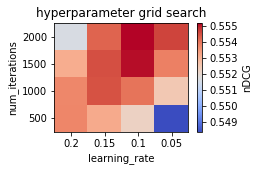

In [14]:
'''
mean_scores_full = np.genfromtxt('grid_search.csv', delimiter=',')
plt.figure(figsize=(3,2))
plt.imshow(mean_scores_full[:,:], aspect='auto', cmap=plt.cm.coolwarm)
plt.xticks(range(4),[0.2,0.15, 0.1, 0.05])
plt.yticks(range(4), [2000,1500,1000,500])
plt.xlabel('learning_rate')
plt.ylabel('num_iterations')
plt.title('hyperparameter grid search')
cb = plt.colorbar()
cb.set_label('nDCG')
plt.savefig('output/grid_numiter_rate_full_final.pdf', bbox_inches='tight')
'''

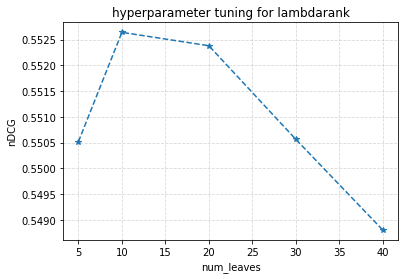

In [23]:

x_str = 'num_leaves'
plt.figure()
plt.plot(param_range, mean_scores,marker='*',linestyle='--')
plt.xlabel(x_str)
plt.ylabel('nDCG')
plt.title('hyperparameter tuning for lambdarank')
plt.grid(color='gray',alpha=0.3, linestyle='--')
#plt.xticks(np.arange(min(parameter_range), max(parameter_range)+100))
#plt.savefig('output/num_leaves_vs_ndcg_train.pdf',bbox_inches='tight')


## Some extra validation on the untouched portion

In [28]:
# extra check on the portion of the set that was not used in cross-validation at all
test_scores = []
for i,model in enumerate(models):
    prediction = model.predict(untouched_sample)
    test_score = ndcg_calc(untouched_sample[['srch_id','click_bool','booking_bool']], prediction)
    test_scores.append(test_score)
    print('Model {0:d} score is {1:.8f}'.format(i, test_score))

Model 0 score is 0.58911956


In [32]:
models[0].save_model('model0.txt', num_iteration=models[0].best_iteration)

In [15]:
test_scores = np.array(test_scores).reshape((len(param_range1),len(param_range2),num_folds))
test_scores

array([[[ 0.58963718,  0.59103543,  0.59150783],
        [ 0.59230661,  0.59257991,  0.59330553],
        [ 0.59413431,  0.59415575,  0.59436487],
        [ 0.59486995,  0.5949445 ,  0.59532435]],

       [[ 0.59109277,  0.59225605,  0.59272197],
        [ 0.59328169,  0.59343195,  0.59411516],
        [ 0.59457947,  0.59448051,  0.5946907 ],
        [ 0.59465257,  0.59493499,  0.59492204]],

       [[ 0.59295222,  0.59367937,  0.5937853 ],
        [ 0.5938052 ,  0.59420119,  0.594664  ],
        [ 0.59460012,  0.59471977,  0.59465215],
        [ 0.59400588,  0.59370535,  0.59397285]],

       [[ 0.59376283,  0.5943357 ,  0.59412921],
        [ 0.59430716,  0.59413075,  0.59413009],
        [ 0.59397002,  0.59343869,  0.59383513],
        [ 0.59145787,  0.59071984,  0.59076209]]])

In [16]:
mean_test_scores = np.mean(test_scores, axis=2)
#np.savetxt('mean_test_num_leaves_1.csv',mean_test_scores, delimiter=',')
mean_test_scores

array([[ 0.59072681,  0.59273069,  0.59421831,  0.59504626],
       [ 0.5920236 ,  0.5936096 ,  0.59458356,  0.59483653],
       [ 0.5934723 ,  0.59422346,  0.59465735,  0.59389469],
       [ 0.59407591,  0.59418933,  0.59374795,  0.59097993]])

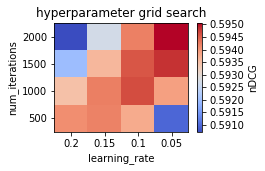

In [21]:
'''
plt.figure(figsize=(3,2))
plt.imshow(mean_test_scores, aspect='auto', cmap=plt.cm.coolwarm)
plt.xticks(range(len(param_range2)),param_range2)
plt.yticks(range(len(param_range1)), param_range1)
plt.xlabel('learning_rate')
plt.ylabel('num_iterations')
plt.title('hyperparameter grid search')
cb = plt.colorbar()
cb.set_label('nDCG')
plt.savefig('output/num_iter_rate_final.pdf', bbox_inches='tight')
'''

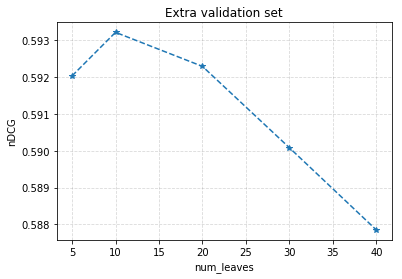

In [27]:
#mean_test_scores = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(param_range[:], mean_test_scores[:], marker='*', linestyle='--')
plt.xlabel(x_str)
plt.ylabel('nDCG')
plt.title('Extra validation set')
plt.grid(color='gray',alpha=0.3, linestyle='--')
#plt.xticks(np.arange(min(parameter_range), max(parameter_range)+100,))
#plt.savefig("output/num_leaves_vs_ndcg_test_1000.pdf", bbox_inches='tight')


In [ ]:
# If results are good save the models into file
for model in models:
    name_str = 'lgmb_models/model' + str(i*k)+'.txt'
    lgbm_model.save_model(name_str)

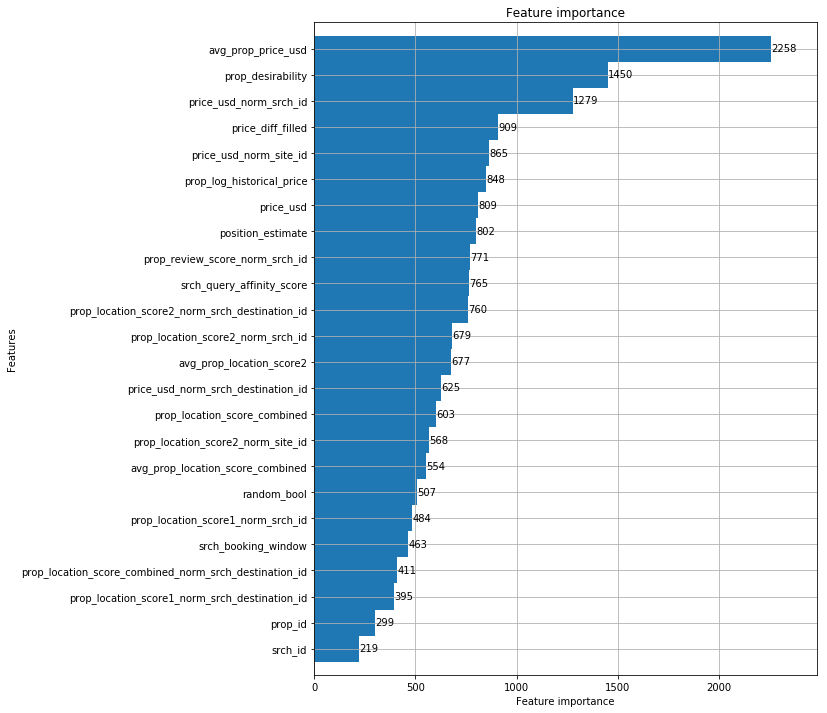

In [9]:
model_ind = -1
lgb.plot_importance(models[model_ind], height=1, figsize=(9,12))
#plt.savefig('output/lightgbm_importances.pdf',bbox_inches='tight')

In [10]:

feature_importances = models[model_ind].feature_importance()
feature_importances_normalized = feature_importances/sum(feature_importances)
feature_names_importances = dict(zip(models[model_ind].feature_name(),feature_importances_normalized))
feature_names_importances = sorted(feature_names_importances.items(), key=lambda x: x[1], reverse=True)[0:23]
feature_names_importances

[('avg_prop_price_usd', 0.12544444444444444),
 ('prop_desirability', 0.080555555555555561),
 ('price_usd_norm_srch_id', 0.071055555555555552),
 ('price_diff_filled', 0.050500000000000003),
 ('price_usd_norm_site_id', 0.048055555555555553),
 ('prop_log_historical_price', 0.047111111111111111),
 ('price_usd', 0.044944444444444447),
 ('position_estimate', 0.044555555555555557),
 ('prop_review_score_norm_srch_id', 0.042833333333333334),
 ('srch_query_affinity_score', 0.042500000000000003),
 ('prop_location_score2_norm_srch_destination_id', 0.042222222222222223),
 ('prop_location_score2_norm_srch_id', 0.037722222222222219),
 ('avg_prop_location_score2', 0.037611111111111109),
 ('price_usd_norm_srch_destination_id', 0.034722222222222224),
 ('prop_location_score_combined', 0.033500000000000002),
 ('prop_location_score2_norm_site_id', 0.031555555555555559),
 ('avg_prop_location_score_combined', 0.030777777777777779),
 ('random_bool', 0.028166666666666666),
 ('prop_location_score1_norm_srch_id'

## Test set ranking

In [4]:
test = pd.read_csv('processed_data_final/test_clean.csv')

In [5]:
test.describe()

,srch_id,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,...,prop_location_score1_norm_site_id,prop_location_score2_norm_site_id,prop_location_score_combined_norm_site_id,prop_review_score_norm_site_id,avg_prop_price_usd,avg_prop_location_score1,avg_prop_location_score2,avg_prop_location_score_combined,avg_prop_review_score,avg_prop_starrating
count,3.514724e+06,3.514724e+06,3.514724e+06,3.514724e+06,3.514724e+06,3.514724e+06,3.514724e+06,3.514724e+06,3.514724e+06,3.514724e+06,...,3.514724e+06,3.514724e+06,3.514724e+06,3.514724e+06,3.514724e+06,3.514724e+06,3.514724e+06,3.514724e+06,3.514724e+06,3.514724e+06
mean,1.181979e+05,9.968928e+00,1.753558e+02,1.736225e+02,7.009914e+04,3.182023e+00,3.771231e+00,6.333891e-01,2.879210e+00,1.572760e-01,...,1.000000e+00,1.000000e+00,9.448429e-01,1.000000e+00,1.510407e+02,2.879210e+00,1.572760e-01,1.023909e-02,3.771231e+00,3.182023e+00
std,6.830756e+04,7.665064e+00,6.583796e+01,6.845271e+01,4.061066e+04,1.050020e+00,1.061171e+00,4.818790e-01,1.534620e+00,1.779591e-01,...,5.235784e-01,1.130658e+00,2.337054e+01,2.839777e-01,8.465447e+01,1.534620e+00,1.145450e-01,8.542759e-01,1.061171e+00,1.050020e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,-2.825585e+02,0.000000e+00,7.000000e-02,0.000000e+00,0.000000e+00,-4.078470e+00,0.000000e+00,0.000000e+00
25%,5.907100e+04,5.000000e+00,1.000000e+02,1.000000e+02,3.504300e+04,3.000000e+00,3.500000e+00,0.000000e+00,1.790000e+00,2.620000e-02,...,6.153458e-01,1.680780e-01,-6.199010e+00,9.119120e-01,9.350462e+01,1.790000e+00,7.273358e-02,-5.717005e-01,3.500000e+00,3.000000e+00
50%,1.182320e+05,5.000000e+00,2.190000e+02,2.190000e+02,6.963800e+04,3.000000e+00,4.000000e+00,1.000000e+00,2.770000e+00,9.440000e-02,...,9.879867e-01,6.042769e-01,3.196899e+00,1.042185e+00,1.299064e+02,2.770000e+00,1.315241e-01,2.622709e-02,4.000000e+00,3.000000e+00
75%,1.774872e+05,1.400000e+01,2.190000e+02,2.190000e+02,1.051790e+05,4.000000e+00,4.500000e+00,1.000000e+00,4.040000e+00,2.239000e-01,...,1.362224e+00,1.424456e+00,1.317063e+01,1.172458e+00,1.855590e+02,4.040000e+00,2.112414e-01,6.476117e-01,4.500000e+00,4.000000e+00
max,2.360740e+05,3.400000e+01,2.310000e+02,2.300000e+02,1.408210e+05,5.000000e+00,5.000000e+00,1.000000e+00,6.980000e+00,1.000000e+00,...,2.938853e+00,8.102168e+00,3.080521e+02,1.718279e+00,5.500000e+02,6.980000e+00,1.000000e+00,2.379370e+00,5.000000e+00,5.000000e+00


In [ ]:
test = test[cols[:-1]]

In [16]:
test.head().T

,0,1,2,3,4
srch_id,1.000000,1.000000,1.000000,1.000000,1.000000
avg_prop_price_usd,125.711653,116.839075,52.172500,134.653069,87.896333
prop_desirability,0.043011,0.053279,0.013423,0.013793,0.014634
price_usd_norm_srch_id,1.268703,1.258042,0.522407,1.524576,0.842248
position_estimate,15.000000,9.000000,21.000000,19.000000,16.000000
price_usd,119.000000,118.000000,49.000000,143.000000,79.000000
prop_log_historical_price,5.030000,4.930000,4.160000,5.030000,4.720000
prop_location_score2_norm_srch_destination_id,0.547723,0.668207,0.440715,0.444678,1.656645
price_usd_norm_site_id,0.763583,0.757166,0.314416,0.917582,0.506916
price_diff_filled,431.000000,432.000000,501.000000,407.000000,471.000000


In [17]:
prediction_score = lgbm_model.predict(test)
prediction = test[['srch_id', 'prop_id']]
prediction['score'] = prediction_score

In [18]:
rank = prediction.groupby(by = 'srch_id')['score'].rank(ascending = False)

In [19]:
rank

0           8.0
1           5.0
2          18.0
3          20.0
4          14.0
5           1.0
6           6.0
7          17.0
8           7.0
9           4.0
10         21.0
11         26.0
12          3.0
13         15.0
14         23.0
15         25.0
16         13.0
17         12.0
18         16.0
19         27.0
20          9.0
21         19.0
22         10.0
23          2.0
24         28.0
25         11.0
26         24.0
27         29.0
28         22.0
29          8.0
           ... 
3514694     1.0
3514695    22.0
3514696     2.0
3514697     1.0
3514698     6.0
3514699     8.0
3514700     2.0
3514701     3.0
3514702     4.0
3514703    10.0
3514704     9.0
3514705     5.0
3514706     7.0
3514707     7.0
3514708     2.0
3514709    13.0
3514710     1.0
3514711     9.0
3514712     8.0
3514713     5.0
3514714    17.0
3514715    11.0
3514716     4.0
3514717    14.0
3514718    15.0
3514719    12.0
3514720     3.0
3514721    16.0
3514722    10.0
3514723     6.0
Name: score, Length: 351

In [23]:
prediction['rank'] = rank

In [25]:
prediction.head(40)

,srch_id,prop_id,score,rank
0,1,3180,-0.227780,8.0
1,1,5543,-0.070283,5.0
2,1,14142,-0.906522,18.0
3,1,22393,-0.972806,20.0
4,1,24194,-0.580180,14.0
5,1,28181,0.217286,1.0
6,1,34263,-0.194034,6.0
7,1,37567,-0.876908,17.0
8,1,50162,-0.219974,7.0
9,1,54937,0.048959,4.0


In [31]:
prediction = prediction.sort_values(['srch_id','rank'],ascending=True)

In [32]:
final_prediction = pd.DataFrame()
final_prediction['SearchId'] = prediction['srch_id']
final_prediction['PropertyId'] = prediction['prop_id']
final_prediction

,SearchId,PropertyId
5,1,28181
23,1,99484
12,1,61934
9,1,54937
1,1,5543
6,1,34263
8,1,50162
0,1,3180
20,1,90385
22,1,95031


In [33]:
final_prediction.to_csv('Group_60.csv',  index=False)